In [1]:
%pylab inline
from crossSection import CrossSection
from ShapeGen import genCirc
from numpy.random import rand,seed

Populating the interactive namespace from numpy and matplotlib


In [8]:
Q = 0.5
nx = 6
xs =linspace(0,500,nx)
zs = linspace(0,1,nx)
seed(5)
rs = 0.1 + rand(nx-1)#*ones(nx-1)
slopes = (zs[1:] - zs[:-1])/(xs[1:] - xs[:-1])
f=0.1
#Generate cross-sections
xcs = []
for r in rs:
    x, y = genCirc(r)
    xc = CrossSection(x,y)
    xcs.append(xc)
    
#Calculate flow depths
h = zeros(nx)
for i, xc in enumerate(xcs):
    #Try calculating flow depth
    fd = xc.calcFlowDepth(Q,slopes[i],f=f)
    print('h-z=',h[i]-zs[i], '  maxdepth=',xc.ymax-xc.ymin)
    if fd ==-1 or (h[i]-zs[i])>(xc.ymax-xc.ymin):
        print(i)
        #We have a full pipe, calculate head gradient instead
        delh = xc.calcPipeFullHeadGrad(Q,slopes[i],f=f)
        print(delh*(xs[i+1] - xs[i]))
        h[i+1] = h[i] + delh * (xs[i+1] - xs[i])
    else:
        if i==0:
            h[0] = fd
        #dz = slopes[i]*(x[i+1] - x[i])
        h[i+1] = zs[i+1] + fd


Pipe is full.
h-z= 0.0   maxdepth= 0.643985547690147
0
1.8669331376819323
h-z= 1.6669331376819323   maxdepth= 1.9414622171596658
Pipe is full.
h-z= 0.17424571497854124   maxdepth= 0.6134375538767878
2
2.3804418259514772
h-z= 2.3546875409300183   maxdepth= 2.0372193025445915
3
0.00589278311930371
h-z= 2.160580324049322   maxdepth= 1.1768209257377116
4
0.09161307456758948


In [9]:
rs

array([0.32199317, 0.97073231, 0.30671916, 1.01861091, 0.58841119])

In [30]:
(xs[1]-xs[0])

100.0

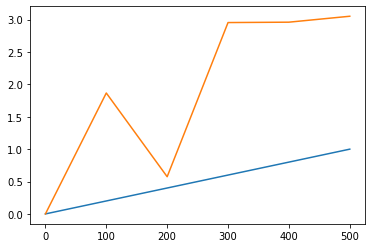

In [5]:
plot(xs,zs,xs,h)
